<h1>Geospatial Data Science</h1>
<h2>Geospatial Data Visualization: folium</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>

This notebook introduces [**folium**](https://python-visualization.github.io/folium/index.html), a python package for creating interactive maps. It provides a quick introduction of the basic folium functionalities. 

Useful links for further functionalities & more advanced plotting:
* Plotting data from [geopandas](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) with folium
* Free tile providers - [http://leaflet-extras.github.io/leaflet-providers/preview/](leaflet)
* Customized [icons](https://getbootstrap.com/docs/3.3/components/)

In [2]:
## Import libraries

import folium

import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.ops import LineString, Point

## Create a base map

In [3]:
# define where to center your map
center = [41.0091982, 28.9662187]

# create a map object
m = folium.Map(location = center, 
               zoom_start = 13, 
               tiles = "OpenStreetMap") 
# the tile indicated here will be the base layer; for more tiles - see below

# display map
display(m)

In [4]:
del(m)

## Add tiles

See documentation under https://python-visualization.github.io/folium/modules.html;

built-in tiles:
        - "OpenStreetMap"
        - "CartoDB positron", "CartoDB dark_matter"
        - etc

You can pass a custom tileset to Folium by passing a Leaflet-style URL to the tiles parameter: http://{s}.yourtiles.com/{z}/{x}/{y}.png.

You can find a list of free tile providers here: http://leaflet-extras.github.io/leaflet-providers/preview/. Be sure to check their terms and conditions and to provide attribution with the attr keyword.

Creating your own map tile layers: https://www.mapbox.com 

In [7]:
## Create tile dictionaries

tiledict_google = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True)
    }

# Explicit tile layer creation allows to change parameters (e.g. opacity)
tiledict_carto = {
    'CartoDB_PositronOnlyLabels': folium.TileLayer(
        tiles = 'https://{s}.basemaps.cartocdn.com/light_only_labels/{z}/{x}/{y}{r}.png', 
        attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',  
        name = 'CartoDB',
        overlay = True,
        control = True)
	
}
    

# create a map object
m = folium.Map(location = center, 
               zoom_start = 13, 
               tiles = "OpenStreetMap") 

## Add tiles to map

for v in tiledict_google.values():
    v.add_to(m)
    
for v in tiledict_carto.values():
    v.add_to(m)
    
## Add layer control (to switch between tiles!)
folium.LayerControl().add_to(m)
    
## Display once again
display(m)

In [6]:
del(m)

## Add markers

* for more symbols: https://getbootstrap.com/docs/3.3/components/ 
* for more sophisticated popups from markers: https://livecodestream.dev/post/how-to-plot-your-data-on-maps-using-python-and-folium/ 

In [8]:
### let's redo the map (to get rid of all the tile layers) and add some markers to it

m = folium.Map(location = center, 
               zoom_start = 13, 
               tiles = "OpenStreetMap")

### Make a dataframe of markers

coords = [[40.98858, 29.0236],[40.98683,29.02686],[41.02586,28.98279]]
titles = ["Hostel", "Bar", "Museum"]
comments = ["great rooftop breakfast", "best mustic ever", "full of paintings"]
links = ["https://hushhostels.com", "http://www.kadyagrup.com/tr/place/view/dunia", "https://www.istanbulmodern.org"]

df = pd.DataFrame({"coord": coords,
                   "title": titles,
                   "comment": comments,
                   "link": links})
df["ht"] = df.apply(lambda x: str(
    "<b>" + str(x.title) + "</b>" + " " + \
    x.comment + \
    " <a href = " + str(x.link) + " target=\"_blank\">" + "(web)" + "</a>"), 
                    axis = 1)
df

,coord,title,comment,link,ht
0,"[40.98858, 29.0236]",Hostel,great rooftop breakfast,https://hushhostels.com,<b>Hostel</b> great rooftop breakfast <a href ...
1,"[40.98683, 29.02686]",Bar,best mustic ever,http://www.kadyagrup.com/tr/place/view/dunia,<b>Bar</b> best mustic ever <a href = http://w...
2,"[41.02586, 28.98279]",Museum,full of paintings,https://www.istanbulmodern.org,<b>Museum</b> full of paintings <a href = http...


In [9]:
df.apply(lambda x: folium.Marker(
    location=x.coord, 
    popup = x.ht, 
    tooltip = x.title,
    icon = folium.Icon("pink",  "glyphicon-heart")).add_to(m), 
         axis = 1);

display(m)

In [10]:
del(m)

## Plot data from OpenStreetMap & use feature groups

OSMnx has functions to create folium maps (less flexible): https://github.com/gboeing/osmnx-examples/blob/main/notebooks/11-plot-routes-folium-web-map.ipynb 

### Preprocessing OSM data

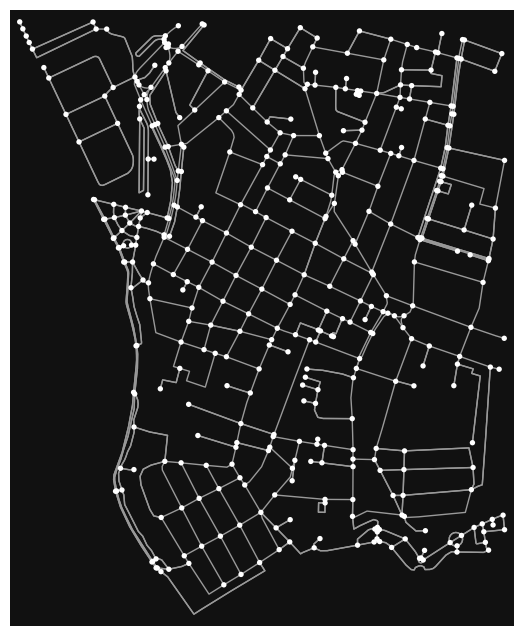

In [12]:
# Create an object to plot (from OSM)
G = ox.graph_from_bbox(40.99, 40.97, 29.03, 29.01,
                            network_type = "all_private",
                            simplify = True,
                            retain_all = False)
ox.plot_graph(G); # show what we've got

In [13]:
# the graph G, acquired with simplify = True, is a MultiDiGraph;
# only edges that have been "simplified" have a geometry attribute.
# one way to quickly plot - add geometry attribute to those edges who have none:

def add_geometry_attribute(G):
    """Add geometry attribute for non-simplified edges"""
    G = G.copy()
    for edge in G.edges:
        if 'geometry' not in G.edges[edge]:
            f_node = [G.nodes[edge[0]]['x'], G.nodes[edge[0]]['y']]
            s_node = [G.nodes[edge[1]]['x'], G.nodes[edge[1]]['y']]
            G.edges[edge]['geometry'] = LineString([Point(*f_node),
                                                   Point(*s_node)])
    return G

G = add_geometry_attribute(G)

# now that all of G's edges have a geometry attribute: store edge data in a gdf,
# convert to the required crs
# and extract the coordinates as lists of tuples (from the linestring geometries)
my_crs = "epsg:4326"
osm_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)
osm_edges = osm_edges.to_crs(my_crs)
osm_edges["coords"] = osm_edges.apply(lambda x: [(c[1], c[0]) for c in x.geometry.coords] , axis = 1)
osm_edges.head(1)

,,,osmid,oneway,name,highway,reversed,length,geometry,lanes,maxspeed,access,service,tunnel,coords
u,v,key,,,,,,,,,,,,,
245940945,2446621629,0,132474412,True,Dr. Esat Işık Caddesi,tertiary,False,69.499,"LINESTRING (29.02884 40.98356, 29.02963 40.98336)",NaN,NaN,NaN,NaN,NaN,"[(40.983565, 29.0288445), (40.9833599, 29.0296..."


### Create a new map, add two feature groups (OSM PolyLines, and Markers)

In [14]:
# Make a new map (centered a bit differently)
m = folium.Map(location = [40.9853,29.0275], 
               zoom_start = 13, 
               tiles = "OpenStreetMap")


### Feature group 1: Street network from OSM

# Create a feature group
kadikoy_fg = folium.FeatureGroup(name = "Kadiköy streets", show = True) # empty fg

# add several lines to the feature group
oneway_lines = folium.PolyLine(locations = osm_edges[osm_edges["oneway"]==True]["coords"], 
                               weight = 4, 
                               color = "#FF33E8", # oneway in pink
                               opacity = 1).add_to(kadikoy_fg)
twoway_lines = folium.PolyLine(locations = osm_edges[osm_edges["oneway"]==False]["coords"], 
                               weight = 3, 
                               color = "#33FFB5",  # twoway in turquoise
                               opacity = 1).add_to(kadikoy_fg)

# add the feature group to the map
kadikoy_fg.add_to(m)

### Feature group 2: markers (from before)

# Create a feature group
markers_fg = folium.FeatureGroup(name = "POIs", show = False)

# add markers to the feature group
df.apply(lambda x: folium.Marker(
    location=x.coord, 
    popup = x.ht, 
    tooltip = x.title,
    icon = folium.Icon("pink",  "glyphicon-heart")).add_to(markers_fg), 
         axis = 1);

# add feature group to map
markers_fg.add_to(m)

# add the layer control to the map
folium.LayerControl().add_to(m)

# display the map
display(m)

### Saving the map as html file

In [15]:
m.save("files/mymap.html")

In [16]:
del(m)

## Creating a heatmap (quick and dirty)

In [17]:
# import folium plugins
from folium import plugins

# Import data - here: handicap parking in Vejle
df = gpd.read_file("http://kortservice.vejle.dk/gis/rest/services/OPENDATA/Vejle/MapServer/3/query?where=p_pladser_handicap%3E0&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&f=pjson")

# Parking spaces are given as polygons - convert into points (centroids)
df["centroid"] = df["geometry"].centroid

# Project to needed crs
df["points_proj"] = df["centroid"].to_crs("EPSG:4326")

# Invert coordinate order to required: (y,x)
df["points_inv"] = df.apply(lambda z: (z.points_proj.y, z.points_proj.x),axis = 1)

df.head(2)

,OBJECTID_1,FEATURE_GROUP,FEATURE_CLASS,SYSTID_FRA,SYSTID_TIL,OPRETTET,OPRINDKODE,STATUSKODE,MYNDIGHED,FAGANSVAR_ID,...,vintervedl,Adgangsadresse,Symbol,Beboer,Shape.STArea(),Shape.STLength(),geometry,centroid,points_proj,points_inv
0,552,Vej og trafik,Parkeringspladser,None,None,1409558885000,0,3,29189900,Jacli,...,None,None,6.0,NaN,11.830000,14.023836,"POLYGON ((533551.790 6173092.626, 533550.390 6...",POINT (533549.238 6173092.329),POINT (9.53383 55.70244),"(55.70244396268443, 9.533834068586327)"
1,555,Vej og trafik,Parkeringspladser,None,None,1409564569000,0,3,29189900,Jacli,...,None,Willy Sørensens Plads 1 7100 Vejle,6.0,NaN,16.877855,16.611107,"POLYGON ((532652.647 6173526.429, 532657.298 6...",POINT (532654.933 6173524.591),POINT (9.51966 55.70639),"(55.7063888658575, 9.51965611794439)"


In [18]:
# create a map, centered in Vejle, with dark background
m = folium.Map(location = [55.7000057, 9.5333238], 
               zoom_start = 11, 
               tiles = "cartodbdark_matter")

# add a heatmap based on the parking spaces;
# heatmap data = list of point coordinates.
plugins.HeatMap(df["points_inv"]).add_to(m);

# display map
display(m)

In [19]:
del(m)